
Name: Rachel Fanti Coelho Lima    
Date: 12/2021     
Subject: LM-18 73005B - Data Profiling - AY 2021-22    
Task: Implementation of FD.


In [37]:
%matplotlib inline

In [38]:
# pip install PyQt5==5.9.2

In [39]:
import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn
import sys

#pip install pandas_profiling --user
#pip install PyQt5==5.9.2
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file

### Input Data 

In [40]:
df = pd.DataFrame([ [ 'C', '3', 'X', 722, 112 ],
                    [ 'A', '1', 'X', 289, 553 ],
                    [ 'A', '1', 'Y', 189, 583 ],
                    [ 'B', '1', 'X', 289, 513 ],
                    [ 'C', '1', 'X', 289, 553 ] ], columns = [a for a in 'abcde'])

In [41]:
'''df = pd.read_csv('./data/wines-2.csv', sep = ",", index_col=False)
df.columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o']
#df.columns = [x for x in range (0, len(df.columns))]'''

'df = pd.read_csv(\'./data/wines-2.csv\', sep = ",", index_col=False)\ndf.columns=[\'a\', \'b\', \'c\', \'d\', \'e\', \'f\', \'g\', \'h\', \'i\', \'j\', \'k\', \'l\', \'m\', \'n\', \'o\']\n#df.columns = [x for x in range (0, len(df.columns))]'

In [42]:
plot_lattice = True

schema = set(a for a in df.columns)

In [43]:
df.head()

,a,b,c,d,e
0,C,3,X,722,112
1,A,1,X,289,553
2,A,1,Y,189,583
3,B,1,X,289,513
4,C,1,X,289,553


In [44]:
schema

{'a', 'b', 'c', 'd', 'e'}

### Layout functions

In [45]:
def layout_lattice(basket):
    from itertools import combinations
    from scipy.special import binom
    G = nx.DiGraph()
    len_max, pos = binom(len(basket), len(basket)/2), {}
    for k in range(1, len(basket)+1):
        sorted_nodes_at_level = sort([set(e) for e in combinations(basket, k)])
        G.add_nodes_from(sorted_nodes_at_level)
        for p, n in enumerate(sorted_nodes_at_level):
            pos[n] = (p + 0.5 * (len_max - len(sorted_nodes_at_level)), k-len(basket))
        nx.draw_networkx_nodes(G, pos, nodelist=sorted_nodes_at_level, node_color='tab:grey')
        
    return G, pos

In [46]:
def mark_as_visited_sup(E, F):
    if not plot_lattice: return
    nx.draw_networkx_nodes(viz[0], viz[1], nodelist=sort(E), node_color='tab:red')
    nx.draw_networkx_nodes(viz[0], viz[1], nodelist=sort(F), node_color='tab:green')
    nx.draw_networkx_labels(viz[0], viz[1], font_size=8, font_color="whitesmoke")
    plt.show()
    plt.pause(1)

def mark_as_visited_gen(f, s):
    if not plot_lattice: return
    edges = [(sort_single(f), sort_single(s))]
    viz[0].add_edges_from(edges)
    nx.draw_networkx_edges(viz[0], viz[1], edgelist=edges, arrows=False)

### Helper functions

In [47]:
def sort_single(s):
    return ''.join(sorted(list(s)))

def sort(F):
    return sorted(sort_single(s) for s in F)

In [48]:
# original to keep
def pli_single(a, D):
    pli = {}
    for row in range(D.shape[0]):
        key = D.at[row, a]
        if key in pli:
            pli[key].add(row)
        else:
            pli[key] = { row }
    return list(v for v in pli.values() if len(v) > 1)

In [49]:
# original to keep
def pli_intersect(p1, p2):
    pli, prob = {}, {}
    for c, s in enumerate(p1):
        for row in s:
            prob[row] = c
    for c, s in enumerate(p2):
        for row in s:
            if row in prob:
                key = (c, prob[row])
                if key in pli:
                    pli[key].add(row)
                else:
                    pli[key] = { row }
            
    return list(v for v in pli.values() if len(v) > 1)

In [50]:
def intersection_sets (set_1, set_2):
    
    '''Finding the common chars for both strings
        
    '''
    result = set() 
    for e in set_1:
        if e in set_2:
            result.add(e)
    return result

In [51]:
#rachel
def set_intersect(X, C):
    
    '''
    e.g.
    Input:
    X = {'b', 'a'}
    C = {'d': {'a', 'b', 'c', 'd', 'e'}, 'e': {'a', 'b', 'c', 'd', 'e'}, 'b': {'a', 'b', 'c'}, 'c': {'a', 'b', 'c', 'd', 'e'}, 'a': {'a', 'c', 'e'}}
    set_intersect(X, C)
    
    Output:
    {'ab': {'a', c'}}
    
    '''
    intersection = {} 
    X = sort_single(X)
    for key, value in C.items():
        if all (k in X for k in key):
            if X in intersection:
                intersection[X]= intersection_sets (intersection[X], value)
            else:
                intersection[X] = value
    return intersection

In [52]:
#rachel 
def get_cardinality (list_of_sets):
    '''calculates the cardinality of a list of sets
    
    e.g. 
    
    Input   
    list_of_sets = [{0, 4}, {1, 2}]
    get_cardinality (list_of_sets)
    
    Output
    4
    '''
    count = 0
    for s in list_of_sets: #for each set in list of sets
        for e in s: # for each element in set
            count += 1
    return count

In [53]:
#rachel
def is_valid(X, A, pli):
    ''' X\A->A - Check if is a functional dependency
    Use key-error and pli to infer FDs (key error can be used with pli and stripped-pli): 
    X->y
    pli(X)=pli(XY)
    cr(X)=Cr(XY) 
               
    Therefore:
    X\A->A 
    Cr(X\A) = Cr(X)    
    
    e.g.
    
    Input:
    X = {'b', 'd'}
    A = 'b'
    pli = {'d': [{1, 3, 4}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}], 'c': [{0, 1, 3, 4}], 'a': [{0, 4}, {1, 2}], 'ab': [{1, 2}], 'ac': [{0, 4}], 'ad': [], 'ae': [], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}]}
    is_valid(X, A, pli)
    
    Output:
    True
    '''

    pli_X_wth_A = pli[sort_single(X).replace(A, '')]
    key_error_X_wth_A = get_cardinality(pli_X_wth_A) - len(pli_X_wth_A) 
    
    pli_X = pli[sort_single(X)]
    key_error_X = get_cardinality(pli_X) - len(pli_X)
    
    if  key_error_X_wth_A == key_error_X:
        return True
    else:
        return False

In [54]:
#rachel
def is_key(X, pli):
    ''' Check if X is a (super)key 
        verify if key_error_X = 0
    
    '''   
    pli_X = pli[sort_single(X)]
    key_error_X = get_cardinality(pli_X) - len(pli_X)
    
    if  key_error_X == 0:
        return True
    else:
        return False

### Funtional dependency discovery algorithm

In [55]:
#rachel
def apriori_fd_discovery(schema, table):
    '''
    Ej: Candidates LHSs
    Fj: validated LHSs
    Cj: candidates RHSs for LHSs
    
    Format: 
    E: [{'c', 'b', 'a'}, {'d', 'c', 'b'}, {'e', 'c', 'b'}, {'d', 'b', 'e'}, {'d', 'c', 'e'}]
    pli: {'ad': [], 'ae': [], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]}
    C = {'d': {'a', 'b', 'c', 'd', 'e'}, 'e': {'a', 'b', 'c', 'd', 'e'}, 'b': {'a', 'b', 'c', 'd', 'e'}, 'c': {'a', 'b', 'c', 'd', 'e'}, 'a': {'a', 'b', 'c', 'd', 'e'}} 
       
    '''
    k=1
    U = []
    E, pli = [set(a) for a in schema], {a: pli_single(a, table) for a in schema} # single attribute sets and PLIs
    C = {sort_single(a): schema for a in schema} # canidates sets for single attributes
    F, U = prune(E, pli, C) # determine the non-unique ones 
    print('\n','E:', E, '\n', 'pli:', pli, '\n', 'C:', C, '\n', 'F:', F)
    while len(F)!=0: # while there are non-dependent LHSs 
        E, pli_next = candidates(F, pli) # create candidate LHSs with one attribute more and PLIs
        pli.update(pli_next)
        C, U_next_1 = dependencies (E, pli, C) # create candidate RHSs for new candidate LHSs
        print('\n','E:', E, '\n', 'pli:', pli, '\n', 'C:', C)
        F, U_next_2 = prune(E, pli, C) # and determine the non-dependent LHSs
                              # increment again the LHSs size 
        U = U + U_next_1 + U_next_2
        U = sorted(U, key = lambda i: (len(i[0]), i[0]))
        print('\n', 'U:', U)
        print('\n', 'F:', F)
        print('--> done with level', k, ' - FDs: ', end ="")
        print(['%s -> %s' % (sort_single(set(u[0])),u[1]) for u in U if len(u[0]) == k]),
        k=k+1
    return U # return the functional dependencies

In [56]:
# original to keep
def candidates(F, pli):
    '''   
    Format:
    E: [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}]
    pli: {'c': [{0, 1, 3, 4}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}], 'd': [{1, 3, 4}], 'ab': [{1, 2}], 'ac': [{0, 4}], 'ad': [], 'ae': [], 'bc': [{1, 3, 4}]}
    
    '''    
    pli_next = pli.copy()
    Fs, E_next = sort(F), []
    for i1 in range(len(Fs)):
        for i2 in range(i1+1, len(Fs)):
            if Fs[i1][:-1] == Fs[i2][:-1] and Fs[i1][-1] < Fs[i2][-1]:
                f = set(fs for fs in Fs[i1]).union({Fs[i2][-1]})
                superset = len(f)
                for i in f:
                    if f.difference({i}) in F:
                        superset -= 1
                if not superset:
                    E_next.append(f)
                    pli_next[sort_single(f)] = pli_intersect(pli_next[sort_single(Fs[i1])],
                                                        pli_next[sort_single(Fs[i2])])
                    mark_as_visited_gen(f, set(s for s in Fs[i1]))
        del pli[sort_single(Fs[i1])]
    return E_next, pli_next

In [57]:
#rachel
def dependencies(E, pli, C): 
    '''
    INPUTs:
    E = [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}, {'d', 'b'}, {'e', 'b'}, {'d', 'c'}, {'c', 'e'}, {'d', 'e'}] 
    pli = {'d': [{1, 3, 4}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}], 'c': [{0, 1, 3, 4}], 'a': [{0, 4}, {1, 2}], 'ab': [{1, 2}], 'ac': [{0, 4}], 'ad': [], 'ae': [], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}]} 
    C = {'d': {'a', 'b', 'c', 'd', 'e'}, 'e': {'a', 'b', 'c', 'd', 'e'}, 'b': {'a', 'b', 'c', 'd', 'e'}, 'c': {'a', 'b', 'c', 'd', 'e'}, 'a': {'a', 'b', 'c', 'd', 'e'}} 
    dependencies(E, pli, C)
 
    E.g.
    LHS = left hand size = X = {'b', 'c', 'e'}
    RHS = right hand size = X-A = {'c', 'e'}
    A = {'b'}
    '''

    Cd  = {} # initialize the set of rhs candidates
    U = []
    for X in E: # traverse the lhs candidates
        rhs = set_intersect(X, C) # Add rhs candidates from previous level
        Cd.update(rhs)
    for X in E: # traverse the lhs candidates (change for x, pli!!)
        for A in sort_single(X):
            if A in Cd[sort_single(X)]: # traverse the rhs candidates
                if is_valid (X, A, pli): # check if valid using key error and pli
                    print ('***FD***', X,'/',A, '-->', A) # then is a minimal funtional dependency                                [C1]
                    U_A = [x for x in X if x != A] # U-A
                    U.append((sort(U_A), A))
                    Cd[sort_single(X)] = Cd[sort_single(X)]-{A} # remove from RHS candidates [C1]
                    print ('C1 - C[', X, ']:', Cd[sort_single(X)])
                    for B in (schema-X): # traverse the candidates
                        Cd[sort_single(X)] = Cd[sort_single(X)]-{B} # remove from RHS candidates [C2]
                    print ('C2 - C[', X, ']:', Cd[sort_single(X)])
    return Cd, U #return the pruned RHS candidates sets and the funtional dependencies

In [58]:
#rachel
def prune(E, pli, C):  
    '''
    Formats:
    E = [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}, {'d', 'b'}, {'e', 'b'}, {'d', 'c'}, {'c', 'e'}, {'d', 'e'}] 
    pli = {'a': [{0, 4}, {1, 2}], 'c': [{0, 1, 3, 4}], 'd': [{1, 3, 4}], 'b': [{1, 2, 3, 4}], 'e': [{1, 4}], 'ad': [], 'ae': [], 'ab': [{1, 2}], 'ac': [{0, 4}], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]}

    C = {'ab': {'a', 'b', 'c', 'd', 'e'}, 'ac': {'a', 'b', 'c', 'd', 'e'}, 'ad': {'a', 'b', 'c', 'd', 'e'}, 'ae': {'a', 'b', 'c', 'd', 'e'}, 'bc': '{'a', 'b', 'c', 'd', 'e'}, 'bd': {'d'}, 'be': {'e'}, 'cd': {'d'}, 'ce': {'e'}, 'de': {'e'}}
    X = {'d', 'a'}
    U = []
    '''
    U=[]
    F = E.copy() # initialize the set of LHSs candidates
    for X in E: # traverse the candidates
        if len(C[sort_single(X)])==0: # if a LHS there is no RHS candidate
            F.remove(X) # remove the LHS form the prefix tree
        if is_key(X, pli): # check if is a (super)key using key-error and pli
            print (sort_single(X) ,'is key')
            for A in ([x for x in C[sort_single(X)] if x not in sort_single(X)]): # traverse the RHSs candidates of X [and iterate in each candidate C[X] - X
                keys_XA_B = [sort_single(X.union(A)).replace(B,"") for B in sort_single(X)] #C[X+A-B] if RHS in all C of augmented LHS subsets [C3]
                print ('keys_XA_B', keys_XA_B)  
                if all (key in C for key in keys_XA_B): # [Check if exist all augmented LHS subsets]
                    #print ('all keys present')
                    #print ('C', C)
                    if all(A in C[k] for k in keys_XA_B): #if RHS in all C of augmented LHS subsets [C3]
                        print ('***FD***', sort_single(X), "-->", A, 'Minimal') # then it is a minimal FD
                        U.append((sort(list(X)), A))
            F.remove(X) # remove the LHS from the prefix tree (everything after this will not be minimal) [key-pruning]  
    mark_as_visited_sup(E, F)
    return F, U # return the pruned set of candidates and the funtional dependencies

In [59]:
''' e.g. C3

E = [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}, {'d', 'b'}, {'e', 'b'}, {'d', 'c'}, {'c', 'e'}, {'d', 'e'}] 
pli = {'a': [{0, 4}, {1, 2}], 'c': [{0, 1, 3, 4}], 'd': [{1, 3, 4}], 'b': [{1, 2, 3, 4}], 'e': [{1, 4}], 'ad': [], 'ae': [], 'ab': [{1, 2}], 'ac': [{0, 4}], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]}
U = []

C = {'ab': {'a', 'b', 'c', 'd', 'e'}, 'ac': {'a', 'b', 'c', 'd', 'e'}, 'ad': {'a', 'b', 'c', 'd', 'e'}, 'ae': {'a', 'b', 'c', 'd', 'e'}, 'bc': '{'a', 'b', 'c', 'd', 'e'}, 'bd': {'d'}, 'be': {'e'}, 'cd': {'d'}, 'ce': {'e'}, 'de': {'e'}}  
X = {'d', 'e'}

# if X is (super)key... in this case X='da'
# you loop through every candidate in C+(X) - X... in this case 'bce' 
# Look the values for C[X+A-B]... in this case, when A=b and iterate B... [ad +b -a], [ad +b -d]
#                                                            for A=b>>    [bd], [ab]
# And then... do the same for A=c and iterate b...           for A=c>>    [cd], [ac]
#                         for A=e...                         for A=e>>    [de], [ae]
# X-->A if A belongs to every candidate sets - false for A=b and A=c
X-->A if A belongs to every candidate sets - true for A=e!

'ad-->e'
'''

" e.g. C3\n\nE = [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}, {'d', 'b'}, {'e', 'b'}, {'d', 'c'}, {'c', 'e'}, {'d', 'e'}] \npli = {'a': [{0, 4}, {1, 2}], 'c': [{0, 1, 3, 4}], 'd': [{1, 3, 4}], 'b': [{1, 2, 3, 4}], 'e': [{1, 4}], 'ad': [], 'ae': [], 'ab': [{1, 2}], 'ac': [{0, 4}], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]}\nU = []\n\nC = {'ab': {'a', 'b', 'c', 'd', 'e'}, 'ac': {'a', 'b', 'c', 'd', 'e'}, 'ad': {'a', 'b', 'c', 'd', 'e'}, 'ae': {'a', 'b', 'c', 'd', 'e'}, 'bc': '{'a', 'b', 'c', 'd', 'e'}, 'bd': {'d'}, 'be': {'e'}, 'cd': {'d'}, 'ce': {'e'}, 'de': {'e'}}  \nX = {'d', 'e'}\n\n# if X is (super)key... in this case X='da'\n# you loop through every candidate in C+(X) - X... in this case 'bce' \n# Look the values for C[X+A-B]... in this case, when A=b and iterate B... [ad +b -a], [ad +b -d]\n#                                

In [60]:
''' e.g. C3 (ilustrative, not real)

E = [{'c', 'b', 'a'}, {'d', 'c', 'b'}, {'e', 'c', 'b'}, {'d', 'b', 'e'}, {'d', 'c', 'e'}]
pli = {'a': [{0, 4}, {1, 2}], 'c': [{0, 1, 3, 4}], 'd': [{1, 3, 4}], 'b': [{1, 2, 3, 4}], 'e': [{1, 4}], 'ad': [], 'ae': [], 'ab': [{1, 2}], 'ac': [{0, 4}], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]}
U = {}

C = {'abc': 'abcde', 'abe': 'e', 'ace': 'e', 'bcd': 'd', 'bce': 'e', 'bde': '', 'cde': ''}
X = {'a', 'b', 'c'}

# if X is (super)key, 
# you loop through every candidate in C+(X) - X... in this case 'de' 
# Look the values for C[X+A-B]... in this case A=d and iterate b... [abc +d -a], [abc +d -b], [abc +d -c]
#                                                      for d= [bcd], [acd], [abd]
# And then... do the same A=e and iterate b...         for e = [bce], [ace], [abe]
# X-->A if A belongs to every candidate sets - false # in this case 'acd' and 'abd' do not exist!
# X-->A if A belongs to every candidate sets - true

'abc-->e'
'''

" e.g. C3 (ilustrative, not real)\n\nE = [{'c', 'b', 'a'}, {'d', 'c', 'b'}, {'e', 'c', 'b'}, {'d', 'b', 'e'}, {'d', 'c', 'e'}]\npli = {'a': [{0, 4}, {1, 2}], 'c': [{0, 1, 3, 4}], 'd': [{1, 3, 4}], 'b': [{1, 2, 3, 4}], 'e': [{1, 4}], 'ad': [], 'ae': [], 'ab': [{1, 2}], 'ac': [{0, 4}], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]}\nU = {}\n\nC = {'abc': 'abcde', 'abe': 'e', 'ace': 'e', 'bcd': 'd', 'bce': 'e', 'bde': '', 'cde': ''}\nX = {'a', 'b', 'c'}\n\n# if X is (super)key, \n# you loop through every candidate in C+(X) - X... in this case 'de' \n# Look the values for C[X+A-B]... in this case A=d and iterate b... [abc +d -a], [abc +d -b], [abc +d -c]\n#                                                      for d= [bcd], [acd], [abd]\n# And then... do the same A=e and iterate b...         for e = [bce], [ace], [abe]\n# X-->A if A belongs to every can

### Run

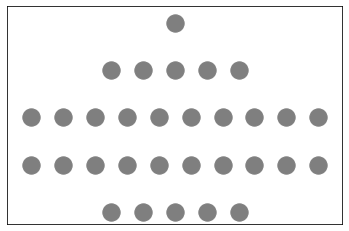

In [61]:
if plot_lattice:
    viz = layout_lattice(schema)
    plt.ion()

   a  b  c    d    e
0  C  3  X  722  112
1  A  1  X  289  553
2  A  1  Y  189  583
3  B  1  X  289  513
4  C  1  X  289  553

Funtional dependency discovery on abcde


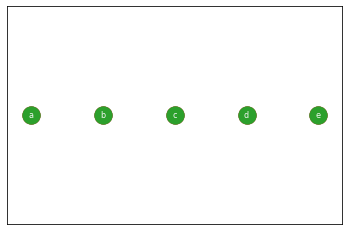


 E: [{'d'}, {'c'}, {'a'}, {'e'}, {'b'}] 
 pli: {'d': [{1, 3, 4}], 'c': [{0, 1, 3, 4}], 'a': [{0, 4}, {1, 2}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}]} 
 C: {'d': {'d', 'c', 'a', 'e', 'b'}, 'c': {'d', 'c', 'a', 'e', 'b'}, 'a': {'d', 'c', 'a', 'e', 'b'}, 'e': {'d', 'c', 'a', 'e', 'b'}, 'b': {'d', 'c', 'a', 'e', 'b'}} 
 F: [{'d'}, {'c'}, {'a'}, {'e'}, {'b'}]
***FD*** {'d', 'b'} / b --> b
C1 - C[ {'d', 'b'} ]: {'d', 'c', 'e', 'a'}
C2 - C[ {'d', 'b'} ]: {'d'}
***FD*** {'e', 'b'} / b --> b
C1 - C[ {'e', 'b'} ]: {'d', 'c', 'e', 'a'}
C2 - C[ {'e', 'b'} ]: {'e'}
***FD*** {'d', 'c'} / c --> c
C1 - C[ {'d', 'c'} ]: {'d', 'b', 'e', 'a'}
C2 - C[ {'d', 'c'} ]: {'d'}
***FD*** {'e', 'c'} / c --> c
C1 - C[ {'e', 'c'} ]: {'d', 'b', 'e', 'a'}
C2 - C[ {'e', 'c'} ]: {'e'}
***FD*** {'d', 'e'} / d --> d
C1 - C[ {'d', 'e'} ]: {'c', 'b', 'e', 'a'}
C2 - C[ {'d', 'e'} ]: {'e'}

 E: [{'b', 'a'}, {'c', 'a'}, {'d', 'a'}, {'e', 'a'}, {'c', 'b'}, {'d', 'b'}, {'e', 'b'}, {'d', 'c'}, {'e', 'c'}, {'d', 'e'}] 
 pli: {'d': [{

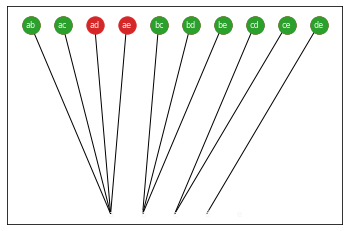


 U: [(['d'], 'b'), (['d'], 'c'), (['e'], 'b'), (['e'], 'c'), (['e'], 'd'), (['a', 'd'], 'e')]

 F: [{'b', 'a'}, {'c', 'a'}, {'c', 'b'}, {'d', 'b'}, {'e', 'b'}, {'d', 'c'}, {'e', 'c'}, {'d', 'e'}]
--> done with level 1  - FDs: ['d -> b', 'd -> c', 'e -> b', 'e -> c', 'e -> d']
***FD*** {'d', 'c', 'b'} / d --> d
C1 - C[ {'d', 'c', 'b'} ]: set()
C2 - C[ {'d', 'c', 'b'} ]: set()

 E: [{'c', 'b', 'a'}, {'d', 'c', 'b'}, {'c', 'e', 'b'}, {'d', 'e', 'b'}, {'d', 'e', 'c'}] 
 pli: {'d': [{1, 3, 4}], 'c': [{0, 1, 3, 4}], 'a': [{0, 4}, {1, 2}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}], 'ad': [], 'ae': [], 'ab': [{1, 2}], 'ac': [{0, 4}], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}], 'abc': [], 'bcd': [{1, 3, 4}], 'bce': [{1, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}]} 
 C: {'abc': {'d', 'a', 'c', 'e', 'b'}, 'bcd': set(), 'bce': {'e'}, 'bde': set(), 'cde': set()}
abc is key
keys_XA_B ['bcd', 'acd', 'abd']
keys_XA_B ['bce', 'ace', 'abe']


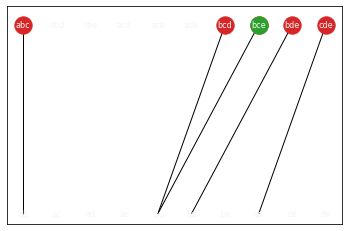


 U: [(['d'], 'b'), (['d'], 'c'), (['e'], 'b'), (['e'], 'c'), (['e'], 'd'), (['a', 'd'], 'e'), (['b', 'c'], 'd')]

 F: [{'c', 'e', 'b'}]
--> done with level 2  - FDs: ['ad -> e', 'bc -> d']

 E: [] 
 pli: {'d': [{1, 3, 4}], 'c': [{0, 1, 3, 4}], 'a': [{0, 4}, {1, 2}], 'e': [{1, 4}], 'b': [{1, 2, 3, 4}], 'ad': [], 'ae': [], 'ab': [{1, 2}], 'ac': [{0, 4}], 'bc': [{1, 3, 4}], 'bd': [{1, 3, 4}], 'be': [{1, 4}], 'cd': [{1, 3, 4}], 'ce': [{1, 4}], 'de': [{1, 4}], 'abc': [], 'bcd': [{1, 3, 4}], 'bde': [{1, 4}], 'cde': [{1, 4}], 'bce': [{1, 4}]} 
 C: {}


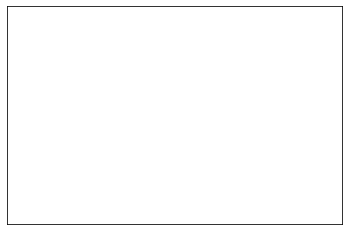


 U: [(['d'], 'b'), (['d'], 'c'), (['e'], 'b'), (['e'], 'c'), (['e'], 'd'), (['a', 'd'], 'e'), (['b', 'c'], 'd')]

 F: []
--> done with level 3  - FDs: []


discovered 7 minimal FDs in 4.798936605453491  seconds

***All FDs:
['d -> b', 'd -> c', 'e -> b', 'e -> c', 'e -> d', 'ad -> e', 'bc -> d']


In [62]:
# run it
print(df.head())
print('')
print('Funtional dependency discovery on', sort_single(schema))

'''
profile = ProfileReport(table, title="dataset", explorative=True)
profile.to_file("./report.html")
'''

fd_start = time.time()
fd = apriori_fd_discovery(schema, df)

# print it
print('\n\ndiscovered', len(fd), 'minimal FDs in', time.time() - fd_start, ' seconds')
print('\n***All FDs:')
print(['%s -> %s' % (sort_single(set(u[0])),u[1]) for u in fd]),

if plot_lattice:    
    plt.ioff()
    plt.show()